In [1]:
!pip install gpytorch
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install stable-baselines3[extra]
!pip install huggingface_hub
!pip install huggingface-sb3
!pip install river

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [12]:
import numpy as np
import pandas as pd

import pickle

import math

import gymnasium as gym
from gym.envs.classic_control.continuous_mountain_car import Continuous_MountainCarEnv
from gymnasium.wrappers import TransformReward, TransformObservation

from sklearn.metrics import mean_squared_error as mse
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import scipy
from scipy.stats import norm
from scipy.special import logsumexp

import gpytorch
import torch
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

from huggingface_sb3 import load_from_hub
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import is_wrapped

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

import scipy
from scipy.stats import multivariate_normal

from collections import deque
from typing import Optional, Tuple

from river import drift

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Create Drifted Environment Class

In [4]:
class Continuous_MountainCarEnvWithWind(Continuous_MountainCarEnv):
  def __init__(self, render_mode: Optional[str] = None, goal_velocity=0, wind_direction="left",
               windpower=0.35):
    super().__init__(render_mode, goal_velocity)
    self.wind_direction = wind_direction
    self.windpower = windpower

  def step(self, action: np.ndarray):
        position = self.state[0]
        velocity = self.state[1]
        force = min(max(action[0], self.min_action), self.max_action)

        windforce = max(np.random.normal(self.windpower, 0.015),0.)

        #velocity += force * self.power - 0.0025 * math.cos(3 * position)

        if self.wind_direction == "left":
          # Left Wind
          velocity += (force-windforce) * self.power - 0.0025 * math.cos(3 * position)
        else:
          # Right Wind
          velocity += (force+windforce) * self.power - 0.0025 * math.cos(3 * position)


        if velocity > self.max_speed:
            velocity = self.max_speed
        if velocity < -self.max_speed:
            velocity = -self.max_speed
        position += velocity
        if position > self.max_position:
            position = self.max_position
        if position < self.min_position:
            position = self.min_position
        if position == self.min_position and velocity < 0:
            velocity = 0

        # Convert a possible numpy bool to a Python bool.
        terminated = bool(
            position >= self.goal_position and velocity >= self.goal_velocity
        )

        reward = 0
        if terminated:
            reward = 100.0
        reward -= math.pow(action[0], 2) * 0.1

        self.state = np.array([position, velocity], dtype=np.float32)

        if self.render_mode == "human":
            self.render()
        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return self.state, reward, terminated, False, {}

## Load Trained Policy from HuggingFace

In [5]:
checkpoint = load_from_hub(
    repo_id = "sb3/sac-MountainCarContinuous-v0",
    filename = "sac-MountainCarContinuous-v0.zip",
)

model = SAC.load(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sac-MountainCarContinuous-v0.zip:   0%|          | 0.00/238k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


## Train SVGP StatePredictor on Training Environment

In [6]:
env0 = Continuous_MountainCarEnv()
env0.reset()

array([-0.46389887,  0.        ], dtype=float32)

In [7]:
observations = []
actions = []
rewards = []
dones = []
sources = []
targets = []

obs_t = env0.reset()
observations.append(obs_t)

for i in range(20000):
  action_t, _state = model.predict(obs_t, deterministic=True)
  actions.append(action_t)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)

  done = terminated or truncated
  dones.append(done)

  observations.append(obs_tplus1)
  rewards.append(r_tplus1)
  sources.append(np.concatenate([obs_t, action_t]))
  targets.append(obs_tplus1-obs_t)

  obs_t = obs_tplus1

  if done:
    obs_t = env0.reset()

sources = np.array(sources)
targets = np.array(targets)

n_train = int(len(sources)*0.8)

In [8]:
X_train_env0, X_test_env0, y_train_env0, y_test_env0 = sources[:n_train], sources[n_train:], targets[:n_train],  targets[n_train:]

scaler = StandardScaler()
scaler.fit(X_train_env0)
X_train_env0_scaled = scaler.transform(X_train_env0)
X_test_env0_scaled = scaler.transform(X_test_env0)

# get the number of tasks (the prediction dimensions)
n_tasks = y_train_env0.shape[-1]

# Compute inducing points
n_inducing = 100
kmeans = KMeans(n_clusters=n_inducing).fit(X_train_env0_scaled)
inducing_points = kmeans.cluster_centers_
inducing_points = torch.from_numpy(inducing_points.astype(np.float32))
inducing_points = torch.concat([inducing_points]*n_tasks, dim=0)
inducing_points = inducing_points.reshape(n_tasks, n_inducing, -1)

X_train_env0_tensor = torch.from_numpy(X_train_env0_scaled).contiguous().to(device)
X_test_env0_tensor = torch.from_numpy(X_test_env0_scaled).contiguous().to(device)
y_train_env0_tensor = torch.from_numpy(y_train_env0).contiguous().to(device)
y_test_env0_tensor = torch.from_numpy(y_test_env0).contiguous().to(device)


train_dataset = TensorDataset(X_train_env0_tensor, y_train_env0_tensor)
train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True)
test_dataset = TensorDataset(X_test_env0_tensor, y_test_env0_tensor)
test_loader = DataLoader(test_dataset, batch_size=800, shuffle=False)

class StatePredictor(ApproximateGP):
  def __init__(self, inducing_points):
    inducing_points = inducing_points
    variational_distribution = CholeskyVariationalDistribution(inducing_points.size(-2),
                                                               batch_shape=torch.Size([n_tasks]))

    variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
                                                   VariationalStrategy(self, inducing_points,
                                                       variational_distribution,
                                                       learn_inducing_locations=True),
                                                num_tasks=n_tasks
                                             )

    super(StatePredictor, self).__init__(variational_strategy)
    self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks]),
                                                                                ard_num_dims=X_train_env0_tensor.size(-1)),
                                                    batch_shape = torch.Size([n_tasks])
                                                  )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model_gp_env0 = StatePredictor(inducing_points)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
num_epochs = 3000


model_gp_env0 = model_gp_env0.to(device)
likelihood = likelihood.to(device)

model_gp_env0.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {"params": model_gp_env0.parameters()},
    {"params": likelihood.parameters()},
], lr=0.05)

#scheduler = MultiStepLR(optimizer, milestones=[500, 1000, 1500], gamma=0.5)
scheduler = ExponentialLR(optimizer, gamma=1-1e-3)

# loss object: VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model_gp_env0,
                                    num_data=y_train_env0_tensor.size(0))


best_loss_test = np.inf
losses_train = []
losses_test = []
#epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in range(num_epochs):
  model_gp_env0.train()
  likelihood.train()
  for _, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    optimizer.zero_grad()
    output = model_gp_env0(x_batch)
    loss = -mll(output, y_batch)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses_train.append(loss.item())


  with torch.no_grad():
    model_gp_env0.eval()
    likelihood.eval()
    for _, (x_batch, y_batch) in enumerate(test_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      output = model_gp_env0(x_batch)
      loss = -mll(output, y_batch)
      losses_test.append(loss.item())
  print(f"""Iteration: {i+1}, train loss: {np.mean(losses_train)},
                     test loss: {np.mean(losses_test)}""")

  if np.mean(losses_test) < best_loss_test:
      torch.save(model_gp_env0, "model_gp_env0.pth")
      best_loss_test = np.mean(losses_test)
      print("Best model so far!")

Streaming output truncated to the last 5000 lines.
                     test loss: -6.1176406967720345
Best model so far!
Iteration: 1335, train loss: -6.111083180184584,
                     test loss: -6.117662967666704
Best model so far!
Iteration: 1336, train loss: -6.111107870779268,
                     test loss: -6.117685205221711
Best model so far!
Iteration: 1337, train loss: -6.1111325243682995,
                     test loss: -6.117707409511865
Best model so far!
Iteration: 1338, train loss: -6.111157141123747,
                     test loss: -6.117729580611748
Best model so far!
Iteration: 1339, train loss: -6.111181721128134,
                     test loss: -6.117751718595724
Best model so far!
Iteration: 1340, train loss: -6.11120626439257,
                     test loss: -6.1177738235379335
Best model so far!
Iteration: 1341, train loss: -6.111230771070364,
                     test loss: -6.117795895512295
Best model so far!
Iteration: 1342, train loss: -6.111255241190

In [13]:
# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Environment Drift Detection

In [14]:
env1 = Continuous_MountainCarEnv() # Undrifted Production Environment
env2 = Continuous_MountainCarEnvWithWind(wind_direction="left",
                                         windpower=0.35) # Drifted Production Environment


In [15]:
class StatePredictor(ApproximateGP):
  def __init__(self, inducing_points):
    inducing_points = inducing_points
    variational_distribution = CholeskyVariationalDistribution(inducing_points.size(-2),
                                                               batch_shape=torch.Size([n_tasks]))

    variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
                                                   VariationalStrategy(self, inducing_points,
                                                       variational_distribution,
                                                       learn_inducing_locations=True),
                                                num_tasks=n_tasks
                                             )

    super(StatePredictor, self).__init__(variational_strategy)
    self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks]),
                                                                                ard_num_dims=X_train_env0_tensor.size(-1)),
                                                    batch_shape = torch.Size([n_tasks])
                                                  )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [17]:
# Load the scaler
import pickle

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)


# Load the GP model
model_gp_env0 = torch.load("model_gp_env0.pth")

In [18]:
with torch.no_grad():

  env1_step = 3000
  env2_step = 3000

  total_step = env1_step + env2_step

  compute_mse_steps = 100
  #mse_compute_buffer = deque([], maxlen=compute_mse_steps)
  obs_true = deque([], maxlen=compute_mse_steps)
  obs_predicted = deque([], maxlen=compute_mse_steps)


  n_past_steps_to_store = 500
  replay_buffer = deque([], maxlen=n_past_steps_to_store)

  #mses = deque([], maxlen=n_past_steps_to_store)
  mses_production = []



  env_current = env1
  obs_t = env_current.reset() # Initialize the environment

  for t in range(1, total_step+1):

    if t%500 == 0:
     print(f"step {t}")

    action_t, _state = model.predict(obs_t, deterministic=True)
    obs_tplus1, r_tplus1, terminated, truncated, info = env_current.step(action_t)
    replay_buffer.append([obs_t, action_t, obs_tplus1, r_tplus1, t])

    x = np.concatenate([obs_t, action_t]).reshape(1,-1)
    x = scaler.transform(x)
    x = torch.from_numpy(x)
    x = x.to(device)

    y = obs_tplus1-obs_t

    y_predicted = model_gp_env0(x)



    mses_production.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))


    done = terminated or truncated

    obs_t = obs_tplus1

    if done:
      obs_t = env_current.reset()

    if t==env1_step: ## Environment Drift Happens
      env_current = env2
      obs_t = env_current.reset()



step 500
step 1000
step 1500
step 2000
step 2500
step 3000
step 3500
step 4000
step 4500
step 5000
step 5500
step 6000


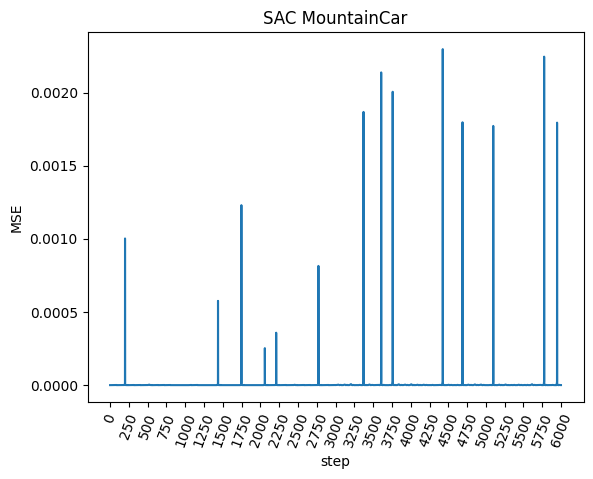

In [19]:
plt.plot(np.array(mses_production))
#plt.axvline(x=3000, label="Environment Drift", color='red')
plt.xlabel("step")
plt.ylabel("MSE")
#plt.legend()
plt.xticks(np.arange(0, 6001, 250), rotation=70)
plt.title("SAC MountainCar")
plt.show()

### Environment Drift Detection with Prob CUSUM

In [20]:
class CusumMeanDetector():
  def __init__(self, mu_ref, sigma_ref, obs_ref, p_limit=0.01) -> None:
    self._mu_ref = mu_ref
    self._sigma_ref = sigma_ref
    self._p_limit = p_limit

    self._reset(obs_ref)

  def _reset(self, obs_ref) -> None:
    self.current_t = len(obs_ref)
    self.current_obs = obs_ref.copy()
    #self.mu_current = self._mu_ref
    #self.sigma_current = self._sigma_ref

  def _update_data(self, y:float) -> None:
    self.current_t += 1
    self.current_obs.append(y)

  def _get_pvalue(self, y, alternative="two-sided") -> float:
    assert alternative in {"two-sided", "greater", "less"}
    pcum = scipy.stats.norm.cdf(y, loc=0., scale=1.)
    if alternative == "two-sided":
      p = 2*(1-pcum)
    if alternative == "greater":
      p = 1-pcum
    if alternative == "less":
      p = pcum
    return p

  def _check_for_changepoint(self, alternative) -> Tuple[float, bool]:
    standardized_sum = np.sum(np.array(self.current_obs)-self._mu_ref)/(self._sigma_ref*self.current_t**0.5)
    p = self._get_pvalue(standardized_sum, alternative)
    return p, p < self._p_limit


  def predict_next(self, y, alternative="two-sided") -> Tuple[float, bool]:
    self._update_data(y)
    p, is_changepoint = self._check_for_changepoint(alternative)
    return p, is_changepoint

In [21]:
# Environment Drift Detection with CUSUM
env0_steps = 4000
window_size = 200
mses_reference = []
p_limit = 0.05
obs_t = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  #x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  #x = scaler.transform(x)
  #x = torch.from_numpy(x.astype("float32")).to(device)
  #action_t_pre = model_gp_env0(x)
  x = np.concatenate([obs_t,action_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x)
  x = x.to(device)

  y = obs_tplus1-obs_t

  with torch.no_grad():
    y_predicted = model_gp_env0(x)



  mses_reference.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t = env0.reset()

#print(f"Reference mean: {np.mean(mses_reference)}, Reference std: {np.std(mses_reference)}")

mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)
mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref = sigma_ref,
                                   obs_ref=mses_reference_window,
                                   p_limit = p_limit)

false_alarms = 0
delay = 4000


for i,val in enumerate(mses_production):
  #drift_detector.add_data_point(val)
  p_value, drift_detected = drift_detector.predict_next(val, alternative="greater")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val}")
    mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()
    drift_detector._reset(mses_reference_window)
    if i < 3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break


print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


### Page-Hinkley

In [22]:
ph = drift.PageHinkley(mode="up", delta=0.005)

env0_steps = 4000
#window_size = 200
mses_reference = []
p_limit = 0.05
obs_t = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  #x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  #x = scaler.transform(x)
  #x = torch.from_numpy(x.astype("float32")).to(device)
  #action_t_pre = model_gp_env0(x)
  x = np.concatenate([obs_t,action_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x)
  x = x.to(device)

  y = obs_tplus1-obs_t

  with torch.no_grad():
    y_predicted = model_gp_env0(x)



  mses_reference.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t = env0.reset()

#print(f"Reference mean: {np.mean(mses_reference)}, Reference std: {np.std(mses_reference)}")

mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  ph.update(val)
  if ph.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 3607, input value: 35.32854461669922
False Alarms: 0, Delay: 607


### ADWIN

In [23]:
adwin = drift.ADWIN()


env0_steps = 4000
mses_reference = []
p_limit = 0.05
obs_t = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)

  x = np.concatenate([obs_t,action_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x)
  x = x.to(device)

  y = obs_tplus1-obs_t

  with torch.no_grad():
    y_predicted = model_gp_env0(x)

  mses_reference.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  adwin.update(val)
  if adwin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


### KSWIN

In [24]:
kswin = drift.KSWIN()


env0_steps = 4000
mses_reference = []
p_limit = 0.05
obs_t = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)

  x = np.concatenate([obs_t,action_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x)
  x = x.to(device)

  y = obs_tplus1-obs_t

  with torch.no_grad():
    y_predicted = model_gp_env0(x)

  mses_reference.append(mse(y, y_predicted.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  kswin.update(val)
  if kswin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 514, input value: 0.02305196039378643
Change detected at index 2775, input value: 0.06515844911336899
Change detected at index 3209, input value: 0.0652991458773613
False Alarms: 2, Delay: 209
